# Predict Zero-inflated and Long/fat-tailed Outcomes

This notebook details how to predict a real-number outcome that is zero-inflated and long/fat-tailed such as sales prediction in retail. We provide baseline regression, regression trained using winsorized outcome, regression trained on log(y+1) outcome, and hurdle regression with and without Duan's method.

## Import

In [ ]:
import pandas as pd
import numpy as np
import random
from ucimlrepo import fetch_ucirepo 
import boto3
import json
from tqdm.auto import tqdm
import time
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, median_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

from scipy.stats import pearsonr, spearmanr, wasserstein_distance
from statsmodels.stats.diagnostic import het_white

def calculate_regression_metrics(y_true, y_pred):
    return {
        'root_mean_squared_error': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mean_squared_error': mean_squared_error(y_true, y_pred),
        'mean_absolute_error': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'pearsonr': pearsonr(y_true, y_pred)[0],  
        'spearmanr': spearmanr(y_true, y_pred)[0],
        'median_absolute_error': median_absolute_error(y_true, y_pred),
        'earths_mover_distance': wasserstein_distance(y_true, y_pred)
    }

def caluclate_classification_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

def string_to_yearmon(date):
    date = date.split()
    date = date[0].split('/') + date[1].split(':')
    date = date[2] + '-' + date[0].zfill(2) #+ '-' + date[1].zfill(2) + ' ' + date[3].zfill(2) + ':' + date[4].zfill(2)
    return date

def call_llama(system_prompt, input):
    template = f"""<s>[INST] <<SYS>>{system_prompt}<</SYS>>{input}[/INST]"""
    client = boto3.client(service_name='bedrock-runtime',region_name='us-west-2')
    body = json.dumps({
        "prompt": template,
        "temperature": 0.,
        "top_p": 0.9,
        "max_gen_len": 2048,
    })
    response = client.invoke_model(
        body=body,
        modelId='us.meta.llama3-2-90b-instruct-v1:0',
        accept='application/json',
        contentType='application/json'
    )
    response_body = json.loads(response['body'].read())
    return response_body

def call_claude(system_prompt, input):
    client = boto3.client(service_name='bedrock-runtime',region_name='us-west-2')
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2048,
            "messages": [
                {
                    "role": "user",
                    "content": [
                    {
                        "type": "text",
                        "text": system_prompt + '\n' + input,
                    }
                    ]
                }
                ]
        }  
    )  

    
    response = client.invoke_model(body=body, 
                                   modelId='anthropic.claude-3-5-sonnet-20241022-v2:0',
                                   contentType='application/json',
                                   accept='application/json')
    response_body = json.loads(response.get('body').read())
   
    return response_body

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

class Winsorizer:
    def __init__(self, cols, percentile=99):
        self.cols = cols  # List of columns to apply winsorization to
        self.percentile = percentile  # Percentile to define the outliers
        self.lower_bounds = {}  # To store the lower quantiles
        self.upper_bounds = {}  # To store the upper quantiles

    def fit(self, df):
        """Fit the winsorizer to the data, remembering the quantiles."""
        for col in self.cols:
            lower = df[col].quantile(1 - self.percentile / 100)
            upper = df[col].quantile(self.percentile / 100)
            self.lower_bounds[col] = lower
            self.upper_bounds[col] = upper
    
    def transform(self, df):
        """Apply winsorization to a new DataFrame using the learned quantiles."""
        for col in self.cols:
            lower = self.lower_bounds[col]
            upper = self.upper_bounds[col]
            df[col] = np.clip(df[col], lower, upper)
        return df

    def fit_transform(self, df):
        """Fit the model and apply winsorization to the same DataFrame."""
        self.fit(df)
        return self.transform(df)

def calculate_vif(df, cols):
    X = df[cols]
    X_with_const = add_constant(X)  # Add constant for VIF calculation
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    return vif_data

import seaborn as sns
import statsmodels.api as sm

## Dataset

We use the [UCI Online Retail](https://archive.ics.uci.edu/dataset/352/online+retail) dataset, which are transactions from a UK-based, non-store online retail from 2010-12-01 and 2011-12-09. We perform the following data processing:

1. Remove transactions without `CustomerID`; from 541,909 to 406,829 transactions
2. Filter out transactions where either `UnitPrice` or `Quantity` is less than zero; from 406,829 to 397,884 transactions
3. Fill in missing product `Description` with value `UNKNOWN`.

In [2]:
online_retail = fetch_ucirepo(id=352) 
transaction_df = online_retail['data']['original']
transaction_df.shape

(541909, 8)

In [3]:
#create yearmon for train-valid split
transaction_df['yearmon'] = transaction_df.InvoiceDate.map(string_to_yearmon)

#get rid of transactions without cid
transaction_df = transaction_df[~transaction_df.CustomerID.isna()].reset_index(drop=True)

#fill in unknown descriptions
transaction_df.Description = transaction_df.Description.fillna('UNKNOWN')

#convert customer id to string
transaction_df['CustomerID'] = transaction_df['CustomerID'].map(lambda x: str(int(x)))

transaction_df.shape

(406829, 9)

In [4]:
#check if still na
transaction_df.isna().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
yearmon        0.0
dtype: float64

In [5]:
#simplify by filtering unit price and quantity to be non-zero (get rid of discounts, cancellations, etc)
transaction_df = transaction_df[(transaction_df.UnitPrice>0)&\
                                (transaction_df.Quantity>0)].reset_index(drop=True)
#add sales
transaction_df['Sales'] = transaction_df.UnitPrice * transaction_df.Quantity
transaction_df.shape

(397884, 10)

## Problem Formulation and Outcome

We formulate the problem as predicting the sales (`TargetSales`) during Q4 2011 for each customers who bought at least one item during Q1-Q3 2011. Note that we are interested in predicting the **actual sales number per customer** as accurately as possible; this is common for marketing use cases such as determining what spend threshold to give each customer in a promotion, targeting customers for upselling, or detecting early signs of churns.

We transform the transaction dataset into a customer-level dataset where we calculate features using transactions between 2011-01 to 2011-09 and outcome using transactions between 2011-10 to 2011-12, summing `Quantity` times `UnitPrice`. We left-join the customers in feature set to outcome set. This will result in the zero-inflated nature of the outcome as not all customers will come back in Q4. The distribution of non-zero sales is naturally long/fat-tailed with a few customers having extraordinarily high amount of sales in Q4. This resulted in a customer-level dataset with 3,438 customers.

In [6]:
feature_period = {'start': '2011-01', 'end': '2011-09'}
outcome_period = {'start': '2011-10', 'end': '2011-12'}

feature_transaction = transaction_df[(transaction_df.yearmon>=feature_period['start'])&\
                                      (transaction_df.yearmon<=feature_period['end'])]
outcome_transaction = transaction_df[(transaction_df.yearmon>=outcome_period['start'])&\
                                      (transaction_df.yearmon<=outcome_period['end'])]
feature_transaction.shape, outcome_transaction.shape

((240338, 10), (131389, 10))

In [7]:
#aggregate sales during outcome period
outcome_sales = outcome_transaction.groupby('CustomerID').Sales.sum().reset_index()
outcome_sales

,CustomerID,Sales
0,12347,1519.14
1,12349,1757.55
2,12352,311.73
3,12356,58.35
4,12357,6207.67
...,...,...
2555,18276,335.86
2556,18277,110.38
2557,18282,77.84
2558,18283,974.21


In [8]:
#aggregate sales during feature period
feature_sales = feature_transaction.groupby('CustomerID').Sales.sum().reset_index()
feature_sales

,CustomerID,Sales
0,12346,77183.60
1,12347,2079.07
2,12348,904.44
3,12350,334.40
4,12352,2194.31
...,...,...
3433,18280,180.60
3434,18281,80.82
3435,18282,100.21
3436,18283,1120.67


In [9]:
#merge to get TargetSales including those who spent during feature period but not during outcome (zeroes)
outcome_df = feature_sales[['CustomerID']].merge(outcome_sales, on='CustomerID', how='left')
outcome_df['Sales'] = outcome_df['Sales'].fillna(0)
outcome_df.columns = ['CustomerID', 'TargetSales']
outcome_df

,CustomerID,TargetSales
0,12346,0.00
1,12347,1519.14
2,12348,0.00
3,12350,0.00
4,12352,311.73
...,...,...
3433,18280,0.00
3434,18281,0.00
3435,18282,77.84
3436,18283,974.21


In [10]:
#confirm zero-inflated, long/fat-tailed
outcome_df.TargetSales.describe(percentiles=[i/10 for i in range(10)])

count      3438.000000
mean        666.245829
std        4016.843037
min           0.000000
0%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%         102.005000
60%         263.006000
70%         425.790000
80%         705.878000
90%        1273.611000
max      168469.600000
Name: TargetSales, dtype: float64

<AxesSubplot:>

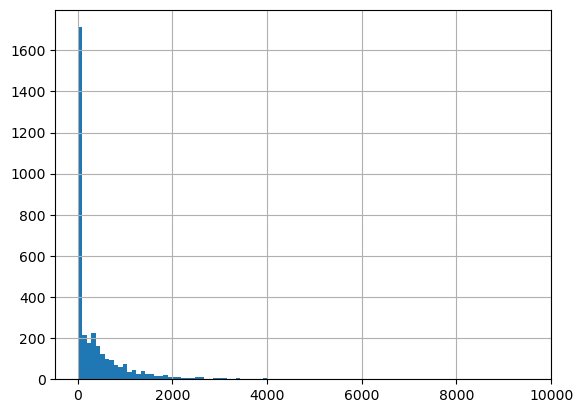

In [11]:
#confirm zero-inflated, long/fat-tailed
outcome_df[outcome_df.TargetSales<=10_000].TargetSales.hist(bins=100)

## Feature

We represent a customer using traditional RFM features namely recency of purchase, purchase days, total sales, number of distinct products purchased, number of distinct category purchased, customer tenure within 2011, average purchase frequency, average purchase value, and percentage of purchase across all 9 categories. This is based on data from Q1-Q3 2011.

Since the [UCI Online Retail](https://archive.ics.uci.edu/dataset/352/online+retail) dataset does not have a category but only contains descriptions over 3,000 items, we use `LLaMA 3.2 90B` to infer categories based on randomly selected 1,000 descriptions. This is to make the category preference representation for each customer, which is more tractable than including features about all 3,000+ items. After that, we use the same model to label a category for each description. The categories are:

1. Home Decor
2. Kitchen and Dining
3. Fashion Accessories
4. Stationary and Gifts
5. Toys and Games
6. Seasonal and Holiday
7. Personal Care and Wellness
8. Outdoor and Garden
9. Others

### Classify `Description` into `Category`

In [12]:
feature_transaction.Description.nunique()

3548

#### Get `Category`

In [13]:
descriptions = feature_transaction.Description.unique().tolist()
print(descriptions[:5])

#randomize descriptions with seed 112 to get which categories we should use
np.random.seed(112)
random_descriptions = np.random.choice(descriptions, 1000, replace=False)
print(random_descriptions[:5])

['JUMBO BAG PINK POLKADOT', 'BLUE POLKADOT WRAP', 'RED RETROSPOT WRAP ', 'RECYCLING BAG RETROSPOT ', 'RED RETROSPOT SHOPPER BAG']
['MODERN FLORAL STATIONERY SET' 'PURPLE BERTIE GLASS BEAD BAG CHARM'
 'PARTY INVITES SPACEMAN' 'MONTANA DIAMOND CLUSTER EARRINGS'
 'SKULLS  DESIGN  COTTON TOTE BAG']


In [14]:
# res = call_llama(
#     'You are a product categorization assistant at a retail website.',
#     'Given the following product descriptions, come up with a few product categories they should be classified into.'+'\n'.join(random_descriptions)
#     )

# print(res['generation'])

In [15]:
# res

In [16]:
# res = call_claude(
#     'You are a product categorization assistant at a retail website.',
#     'Given the following product descriptions, come up with a few product categories they should be classified into.'+'\n'.join(random_descriptions)
#     )

# print(res['content'][0]['text'])

In [17]:
# res

LLaMA 3.2 90B Output:
```
<<SYS>>Based on the product descriptions, I would categorize them into the following categories:

1. Home Decor:
	* Wall art
	* Decorative items (e.g. vases, figurines, etc.)
	* Lighting (e.g. candles, lanterns, etc.)
	* Textiles (e.g. throw pillows, blankets, etc.)
2. Kitchen and Dining:
	* Cookware and utensils
	* Tableware (e.g. plates, cups, etc.)
	* Kitchen decor (e.g. signs, magnets, etc.)
	* Food and drink items (e.g. tea, coffee, etc.)
3. Fashion and Accessories:
	* Jewelry (e.g. necklaces, earrings, etc.)
	* Handbags and wallets
	* Clothing and accessories (e.g. scarves, hats, etc.)
4. Stationery and Gifts:
	* Cards and gift wrap
	* Stationery (e.g. notebooks, pens, etc.)
	* Gift items (e.g. mugs, keychains, etc.)
5. Toys and Games:
	* Toys (e.g. stuffed animals, puzzles, etc.)
	* Games and puzzles
6. Seasonal and Holiday:
	* Christmas decorations and gifts
	* Easter decorations and gifts
	* Other seasonal items (e.g. Halloween, etc.)
7. Personal Care and Wellness:
	* Beauty and personal care items (e.g. skincare, haircare, etc.)
	* Wellness and self-care items (e.g. essential oils, etc.)
8. Outdoor and Garden:
	* Garden decor and accessories
	* Outdoor furniture and decor
	* Gardening tools and supplies

Note that some products may fit into multiple categories, but I have assigned them to the one that seems most relevant.
```

Claude 3.5 v2 Output
```
Based on these product descriptions, I would suggest the following main product categories:

1. Home Decor
- Candle holders
- Picture frames
- Wall art & signs
- Clocks
- Cushions & covers
- Storage items
- Decorative objects

2. Jewelry & Accessories
- Necklaces
- Bracelets
- Earrings
- Hair accessories
- Bag charms
- Key rings

3. Garden & Outdoor
- Plant pots
- Garden tools
- Outdoor decorations
- Bird houses
- Garden markers

4. Kitchen & Dining
- Tea sets
- Mugs
- Kitchen storage
- Cutlery
- Baking accessories
- Tea towels

5. Stationery & Paper Goods
- Notebooks
- Gift wrap
- Cards
- Paper decorations
- Writing sets

6. Party & Celebrations
- Party supplies
- Gift bags
- Christmas decorations
- Easter items
- Birthday items

7. Children's Items
- Toys
- Children's tableware
- School supplies
- Kids' accessories

8. Fashion Accessories
- Bags
- Purses
- Scarves
- Travel accessories

9. Bath & Beauty
- Bathroom accessories
- Toiletry bags
- Beauty items

10. Lighting
- Lamps
- String lights
- Tea lights
- Lanterns

These categories cover the main types of products in the list while providing logical groupings for customers to browse.
```

In [18]:
categories = [
    'Home Decor',
    'Kitchen and Dining',
    'Fashion Accessories',
    'Stationary and Gifts',
    'Toys and Games',
    'Seasonal and Holiday',
    'Personal Care and Wellness',
    'Outdoor and Garden',   
]

len(categories)

8

#### Annotate `Category` to `Description`

In [19]:
# #loop through descriptions in batches of batch_size
# res_texts = []
# batch_size = 100
# for i in tqdm(range(0, len(descriptions), batch_size)):
#     batch = descriptions[i:i+batch_size]
#     d = "\n".join(batch)
#     inp = f'''Categorize the following product descriptions into {", ".join(categories)} or Others, if they do not fall into any. 
# Only answer in the following format:

# "product description of product #1"|"product category classified into"
# "product description of product #2"|"product category classified into"
# ...
# "product description of product #n"|"product category classified into"

# Here are the product descriptions:
# {d}
# '''
#     while True:
#         res = call_claude('You are a product categorizer at a retail website', inp)
#         # if res['generation_token_count'] > 1: #for llama
#         if res['usage']['output_tokens'] > 1:
#             break
#         else:
#             print('Retrying...')
#             time.sleep(2)
#     res_text = res['content'][0]['text'].strip().split('\n')
#         #for llama
#         # .replace('[SYS]','').replace('<<SYS>>','')\
#         # .replace('[/SYS]','').replace('<</SYS>>','')\
#     if res_text!='':
#         res_texts.extend(res_text)

In [20]:
# with open('../data/sales_prediction/product_description_category.csv','w') as f:
#     f.write('"product_description"|"category"\n')
#     for i in res_texts:
#         f.write(f'{i}\n')

In [21]:
product_description_category = pd.read_csv('../data/sales_prediction/product_description_category.csv',
                                           sep='|')

#clean product_description
product_description_category['Description'] = descriptions
product_description_category.category.value_counts(normalize=True)

category
Home Decor                    0.328636
Kitchen and Dining            0.195885
Fashion Accessories           0.138670
Stationary and Gifts          0.116122
Seasonal and Holiday          0.087373
Personal Care and Wellness    0.047351
Toys and Games                0.045096
Outdoor and Garden            0.032976
Others                        0.007892
Name: proportion, dtype: float64

In [22]:
feature_transaction_cat = feature_transaction.merge(product_description_category,
                                                    how='inner',
                                                    on = 'Description',)
feature_transaction.shape, feature_transaction_cat.shape

((240338, 10), (240338, 12))

### RFM

In [23]:
#convert invoice date to datetime
feature_transaction_cat['InvoiceDate'] = pd.to_datetime(feature_transaction_cat['InvoiceDate'])

# last date in feature set
current_date = feature_transaction_cat['InvoiceDate'].max()

#rfm
customer_features = feature_transaction_cat.groupby('CustomerID').agg({
    'InvoiceDate': [
        ('recency', lambda x: (current_date - x.max()).days),
        ('first_purchase_date', 'min'),
        ('purchase_day', 'nunique'),
    ],
    'InvoiceNo': [('nb_invoice', 'nunique')],
    'Sales': [
        ('total_sales', 'sum')
    ],
    'StockCode': [('nb_product', 'nunique')],
    'category': [('nb_category', 'nunique')]
}).reset_index()

# Flatten column names
customer_features.columns = [
    'CustomerID',
    'recency',
    'first_purchase_date',
    'purchase_day',
    'nb_invoice',
    'total_sales',
    'nb_product',
    'nb_category'
]

In [24]:
#almost always one purchase a day
(customer_features.purchase_day==customer_features.nb_invoice).mean()

0.977021524141943

In [25]:
customer_features['customer_lifetime'] = (current_date - customer_features['first_purchase_date']).dt.days
customer_features['avg_purchase_frequency'] = customer_features['customer_lifetime'] / customer_features['purchase_day']
customer_features['avg_purchase_value'] = customer_features['total_sales'] / customer_features['purchase_day']

### Category Preference

In [26]:
#category preference
category_sales = feature_transaction_cat.pivot_table(
    values='Sales', 
    index='CustomerID', 
    columns='category', 
    aggfunc='sum', 
    fill_value=0
)
category_sales.columns = [i.lower().replace(' ','_') for i in category_sales.columns]
customer_features = customer_features.merge(category_sales, on='CustomerID', how='left')

total_sales = customer_features['total_sales']
for col in category_sales.columns:
    percentage_col = f'per_{col}'
    customer_features[percentage_col] = customer_features[col] / total_sales

In [27]:
#make sure the categories are not too sparse
(customer_features.iloc[:,-9:]==0).mean()

per_fashion_accessories           0.409831
per_home_decor                    0.081734
per_kitchen_and_dining            0.122455
per_others                        0.765561
per_outdoor_and_garden            0.507853
per_personal_care_and_wellness    0.448226
per_seasonal_and_holiday          0.369401
per_stationary_and_gifts          0.305410
per_toys_and_games                0.487202
dtype: float64

### Putting Them All Together

In [110]:
selected_features = [
 'recency',
 'purchase_day',
 'total_sales',
 'nb_product',
 'nb_category',
 'customer_lifetime',
 'avg_purchase_frequency',
 'avg_purchase_value',
 'per_fashion_accessories',
 'per_home_decor',
 'per_kitchen_and_dining',
 'per_others',
 'per_outdoor_and_garden',
 'per_personal_care_and_wellness',
 'per_seasonal_and_holiday',
 'per_stationary_and_gifts',
 'per_toys_and_games']

outcome_variable = 'TargetSales'


In [29]:
customer_features = customer_features[[ 'CustomerID']+selected_features]
customer_features.head()

,CustomerID,recency,purchase_day,total_sales,nb_product,nb_category,customer_lifetime,avg_purchase_frequency,avg_purchase_value,per_fashion_accessories,per_home_decor,per_kitchen_and_dining,per_others,per_outdoor_and_garden,per_personal_care_and_wellness,per_seasonal_and_holiday,per_stationary_and_gifts,per_toys_and_games
0,12346,255,1,77183.60,1,1,255,255.000000,77183.600000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12347,59,4,2079.07,65,7,247,61.750000,519.767500,0.145834,0.204168,0.294021,0.000000,0.005628,0.147614,0.000000,0.073013,0.129721
2,12348,5,3,904.44,10,4,248,82.666667,301.480000,0.000000,0.000000,0.000000,0.132679,0.000000,0.825970,0.018796,0.022555,0.000000
3,12350,239,1,334.40,17,7,239,239.000000,334.400000,0.240431,0.202751,0.116926,0.172548,0.000000,0.118421,0.000000,0.059211,0.089713
4,12352,2,7,2194.31,47,8,226,32.285714,313.472857,0.000000,0.196531,0.246187,0.474090,0.013535,0.016680,0.008066,0.024404,0.020508


## Merge Features and Outcome

In [30]:
customer_features.shape, outcome_df.shape

((3438, 18), (3438, 2))

In [31]:
df = outcome_df.merge(customer_features, on='CustomerID').drop('CustomerID', axis=1)
df.shape

(3438, 18)

In [32]:
#correlations
df.iloc[:,1:].corr()

,recency,purchase_day,total_sales,nb_product,nb_category,customer_lifetime,avg_purchase_frequency,avg_purchase_value,per_fashion_accessories,per_home_decor,per_kitchen_and_dining,per_others,per_outdoor_and_garden,per_personal_care_and_wellness,per_seasonal_and_holiday,per_stationary_and_gifts,per_toys_and_games
recency,1.000000,-0.299308,-0.132344,-0.287415,-0.326772,0.298853,0.893973,0.008823,-0.020861,0.022013,0.057244,-0.016069,0.071268,-0.082792,-0.085681,-0.017813,-0.009686
purchase_day,-0.299308,1.000000,0.540253,0.690345,0.304621,0.332109,-0.331543,0.027488,0.030683,0.018684,0.025269,0.004299,-0.019992,-0.035665,-0.020392,-0.045384,-0.028187
total_sales,-0.132344,0.540253,1.000000,0.400467,0.137064,0.156018,-0.148762,0.361138,0.016511,-0.013819,0.047834,0.006398,-0.029353,-0.011937,-0.016724,-0.029181,-0.013139
nb_product,-0.287415,0.690345,0.400467,1.000000,0.555551,0.265594,-0.294923,0.061039,-0.003137,-0.017516,0.035615,-0.006842,-0.026371,-0.005309,-0.016586,0.026716,-0.010069
nb_category,-0.326772,0.304621,0.137064,0.555551,1.000000,0.224232,-0.321596,0.019955,0.004863,-0.138372,-0.039363,0.055555,0.041405,0.075882,0.015498,0.152869,0.111150
customer_lifetime,0.298853,0.332109,0.156018,0.265594,0.224232,1.000000,0.358431,0.014933,0.011220,0.066111,0.069175,-0.019971,0.029726,-0.127865,-0.120399,-0.050320,-0.036484
avg_purchase_frequency,0.893973,-0.331543,-0.148762,-0.294923,-0.321596,0.358431,1.000000,0.009157,-0.016093,0.027208,0.037053,-0.027413,0.060369,-0.070352,-0.074799,-0.000546,-0.010612
avg_purchase_value,0.008823,0.027488,0.361138,0.061039,0.019955,0.014933,0.009157,1.000000,-0.003187,-0.056690,0.076862,0.015427,-0.028884,0.004225,-0.000200,-0.012729,-0.002396
per_fashion_accessories,-0.020861,0.030683,0.016511,-0.003137,0.004863,0.011220,-0.016093,-0.003187,1.000000,-0.254015,-0.177775,-0.010436,-0.082834,-0.038493,-0.124719,-0.068166,-0.051486
per_home_decor,0.022013,0.018684,-0.013819,-0.017516,-0.138372,0.066111,0.027208,-0.056690,-0.254015,1.000000,-0.481983,-0.155784,-0.080637,-0.158837,-0.165964,-0.262313,-0.245759


<AxesSubplot:xlabel='TargetSales', ylabel='total_sales'>

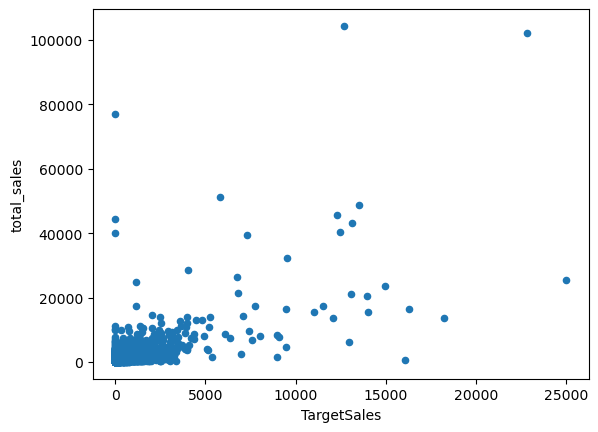

In [33]:
#target and most predictive variable
df[df.TargetSales<=25_000].plot.scatter(x='TargetSales',y='total_sales')

## Train-Test Splits

We randomly split the dataset into train and test sets at 80/20 ratio. We also confirm the distribution of `TargetSales` is similar across percentiles and only different at the upper end.

In [34]:
#split into train-valid sets
train_df, test_df = train_test_split(df,
                                      test_size=0.2, 
                                      random_state=112)

In [35]:
pd.concat([train_df.TargetSales.describe(percentiles=[i/10 for i in range(10)]).reset_index(),
test_df.TargetSales.describe(percentiles=[i/10 for i in range(10)]).reset_index(),], axis=1)

,index,TargetSales,index,TargetSales
0,count,2750.000000,count,688.000000
1,mean,642.650436,mean,760.558808
2,std,4015.305436,std,4024.524400
3,min,0.000000,min,0.000000
4,0%,0.000000,0%,0.000000
5,10%,0.000000,10%,0.000000
6,20%,0.000000,20%,0.000000
7,30%,0.000000,30%,0.000000
8,40%,0.000000,40%,0.000000
9,50%,91.350000,50%,113.575000


## Baseline Regression

The most naive solution is to predict `TargetSales` based on the features. We use a stacked ensemble of LightGBM, CatBoost, XGBoost, Random Forest and Extra Trees via AutoGluon. We train with `good_quality` preset, stated to be "Stronger than any other AutoML Framework", for speedy training and inference but feel free to try more performant option. We exclude the neural-network models as they require further preprocessing of the features.

We use an industry-grade, non-parametric model to be as close to a real use case as possible and make a point that our methodology works not only in a toy-dataset setup.

In [36]:
preset = 'good_quality'

In [37]:
predictor = TabularPredictor(label='TargetSales').fit(train_df[selected_features + ['TargetSales']], 
                                                      presets=preset,
                                                      excluded_model_types=['NN_TORCH','FASTAI','KNN'],
                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_134505"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 01:22:11 UTC 2024
CPU Count:          64
Memory Avail:       470.24 GB / 480.23 GB (97.9%)
Disk Space Avail:   1451.64 GB / 1968.52 GB (73.7%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynam

[1000]	valid_set's rmse: 4314.99


	-3894.7078	 = Validation score   (-root_mean_squared_error)
	5.58s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 846.2s of the 846.19s of remaining time.
	-4525.2057	 = Validation score   (-root_mean_squared_error)
	0.87s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 845.08s of the 845.07s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-3904.7749	 = Validation score   (-root_mean_squared_error)
	5.45s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 839.51s of the 839.5s of remaining time.
	-3952.2022	 = Validation score   (-root_mean_squared_error)
	0.68s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ... Training model for up to 838.57s of the 838.56s of remaining time.
	Fitting 8 child mo

[1000]	valid_set's rmse: 9800.07
[2000]	valid_set's rmse: 9792.42
[3000]	valid_set's rmse: 9791.47


	-3713.1197	 = Validation score   (-root_mean_squared_error)
	8.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 3505.33s of the 3505.33s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 9561.64
[2000]	valid_set's rmse: 9538.68


	-3635.1505	 = Validation score   (-root_mean_squared_error)
	6.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 3499.08s of the 3499.08s of remaining time.
	-4135.0334	 = Validation score   (-root_mean_squared_error)
	0.82s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 3497.99s of the 3497.99s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-3669.0125	 = Validation score   (-root_mean_squared_error)
	18.54s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 3479.34s of the 3479.34s of remaining time.
	-3678.3921	 = Validation score   (-root_mean_squared_error)
	0.66s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ... Training model for up to 3478.41s of the 3478.41s of remaining time.
	Fitting

In [38]:
test_df['pred_baseline'] = predictor.predict(test_df[selected_features])

In [39]:
metric_baseline = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_baseline'])
metric_baseline['model'] = 'baseline'
metric_baseline

{'root_mean_squared_error': 3162.478744240967,
 'mean_squared_error': 10001271.807775924,
 'mean_absolute_error': 715.6442657130541,
 'r2': 0.3816166296854987,
 'pearsonr': 0.6190719671013133,
 'spearmanr': 0.47008461549340863,
 'median_absolute_error': 232.98208312988282,
 'earths_mover_distance': 287.77728784026124,
 'model': 'baseline'}

## Regression on Winsorized Outcome

One possible approach to deal with long/fat-tailed outcome is to train on a winsorized outcome. This may lead to better performance when tested on a winsorized outcome but not so much on original outcome.

In [40]:
outlier_per = 0.99
outlier_cap_train = train_df['TargetSales'].quantile(outlier_per)
outlier_cap_train

7180.805199999947

In [41]:
#winsorize
train_df['TargetSales_win'] = train_df['TargetSales'].map(lambda x: outlier_cap_train if x> outlier_cap_train else x)
test_df['TargetSales_win'] = test_df['TargetSales'].map(lambda x: outlier_cap_train if x> outlier_cap_train else x)

In [42]:
predictor = TabularPredictor(label='TargetSales_win').fit(train_df[selected_features+['TargetSales_win']],
                                                      presets=preset,
                                                      excluded_model_types=['NN_TORCH','FASTAI','KNN'],
                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_134727"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 01:22:11 UTC 2024
CPU Count:          64
Memory Avail:       468.94 GB / 480.23 GB (97.6%)
Disk Space Avail:   1451.56 GB / 1968.52 GB (73.7%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynam

[1000]	valid_set's rmse: 622.335
[2000]	valid_set's rmse: 619.896
[3000]	valid_set's rmse: 619.36
[4000]	valid_set's rmse: 619.228
[5000]	valid_set's rmse: 619.165
[6000]	valid_set's rmse: 619.15
[7000]	valid_set's rmse: 619.144
[8000]	valid_set's rmse: 619.142
[9000]	valid_set's rmse: 619.14
[10000]	valid_set's rmse: 619.14


	-669.5782	 = Validation score   (-root_mean_squared_error)
	16.28s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 837.9s of the 837.89s of remaining time.
	-702.8194	 = Validation score   (-root_mean_squared_error)
	0.88s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 836.75s of the 836.74s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-679.668	 = Validation score   (-root_mean_squared_error)
	13.36s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 823.27s of the 823.26s of remaining time.
	-688.2802	 = Validation score   (-root_mean_squared_error)
	0.68s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ... Training model for up to 822.32s of the 822.31s of remaining time.
	Fitting 8 child mode

In [43]:
test_df['pred_winsorized'] = predictor.predict(test_df[selected_features])

In [44]:
metric_winsorized = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_winsorized'])
metric_winsorized['model'] = 'winsorized'
metric_winsorized

{'root_mean_squared_error': 3623.576377551195,
 'mean_squared_error': 13130305.76394704,
 'mean_absolute_error': 627.7880071099414,
 'r2': 0.18814697894155963,
 'pearsonr': 0.5757989413256978,
 'spearmanr': 0.504301956183441,
 'median_absolute_error': 219.62248107910156,
 'earths_mover_distance': 432.1288432991232,
 'model': 'winsorized'}

In [45]:
calculate_regression_metrics(test_df['TargetSales_win'], test_df['pred_winsorized'])

{'root_mean_squared_error': 673.4846433338375,
 'mean_squared_error': 453581.5648065064,
 'mean_absolute_error': 376.77603327273135,
 'r2': 0.6171771763549553,
 'pearsonr': 0.7865724180212539,
 'spearmanr': 0.504299950810919,
 'median_absolute_error': 218.8311004638672,
 'earths_mover_distance': 181.1168694619127}

## Log1p Regression

Log transformation handles long/fat-tailed distribution and is especially useful for certain models since the transformed distribution is roughly normal. However, it cannot handle zero-valued outcome and oftentimes scientists end up adding 1 to the outcome (so often that `numpy` even has a function for it). This not only introduces bias to the prediction, but also does not solve the zero-inflation as it becomes one-inflation instead.

In [46]:
#log
train_df['TargetSales_log1p'] = train_df['TargetSales'].map(np.log1p)
test_df['TargetSales_log1p'] = test_df['TargetSales'].map(np.log1p)

<AxesSubplot:>

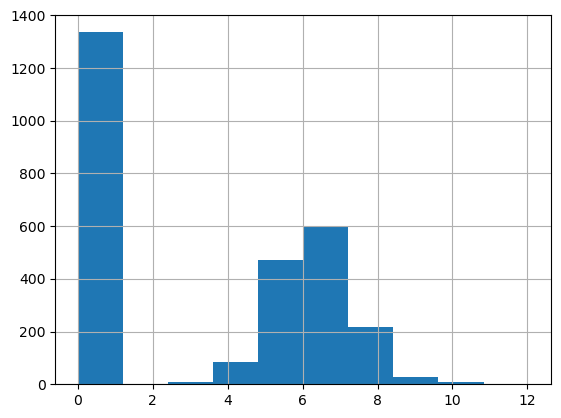

In [47]:
#from zero-inflated to one-inflated
train_df['TargetSales_log1p'].hist()

In [48]:
predictor = TabularPredictor(label='TargetSales_log1p').fit(train_df[selected_features+['TargetSales_log1p']],
                                                      presets=preset,
                                                      excluded_model_types=['NN_TORCH','FASTAI','KNN'],
                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_134958"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 01:22:11 UTC 2024
CPU Count:          64
Memory Avail:       468.19 GB / 480.23 GB (97.5%)
Disk Space Avail:   1451.46 GB / 1968.52 GB (73.7%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynam

[1000]	valid_set's rmse: 2.69718
[2000]	valid_set's rmse: 2.65909
[3000]	valid_set's rmse: 2.65127
[4000]	valid_set's rmse: 2.64831
[5000]	valid_set's rmse: 2.64686
[6000]	valid_set's rmse: 2.64619
[7000]	valid_set's rmse: 2.64592
[8000]	valid_set's rmse: 2.64577
[9000]	valid_set's rmse: 2.64574
[10000]	valid_set's rmse: 2.64573
[1000]	valid_set's rmse: 2.69753
[2000]	valid_set's rmse: 2.65357
[3000]	valid_set's rmse: 2.64919
[4000]	valid_set's rmse: 2.64645
[5000]	valid_set's rmse: 2.64479
[6000]	valid_set's rmse: 2.64422
[7000]	valid_set's rmse: 2.6439
[8000]	valid_set's rmse: 2.64387
[9000]	valid_set's rmse: 2.64384
[10000]	valid_set's rmse: 2.64383
[1000]	valid_set's rmse: 2.71185
[2000]	valid_set's rmse: 2.66777
[3000]	valid_set's rmse: 2.65641
[4000]	valid_set's rmse: 2.65399
[5000]	valid_set's rmse: 2.65317
[6000]	valid_set's rmse: 2.65306
[7000]	valid_set's rmse: 2.65305
[1000]	valid_set's rmse: 2.73753
[2000]	valid_set's rmse: 2.69713
[3000]	valid_set's rmse: 2.68365
[4000]	va

	-2.6944	 = Validation score   (-root_mean_squared_error)
	52.47s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 813.19s of the 813.18s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 2.64699
[2000]	valid_set's rmse: 2.64384
[3000]	valid_set's rmse: 2.64347
[4000]	valid_set's rmse: 2.64345
[1000]	valid_set's rmse: 2.6483
[1000]	valid_set's rmse: 2.87823


	-2.7598	 = Validation score   (-root_mean_squared_error)
	9.99s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 803.1s of the 803.09s of remaining time.
	-2.8088	 = Validation score   (-root_mean_squared_error)
	0.75s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 802.07s of the 802.06s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-2.759	 = Validation score   (-root_mean_squared_error)
	92.85s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 709.08s of the 709.07s of remaining time.
	-2.778	 = Validation score   (-root_mean_squared_error)
	0.66s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ... Training model for up to 708.14s of the 708.13s of remaining time.
	Fitting 8 child models (S1F1 -

[1000]	valid_set's rmse: 2.76447
[1000]	valid_set's rmse: 2.80146
[2000]	valid_set's rmse: 2.8014
[3000]	valid_set's rmse: 2.8014
[4000]	valid_set's rmse: 2.8014
[1000]	valid_set's rmse: 2.88446
[2000]	valid_set's rmse: 2.88439


	-2.7943	 = Validation score   (-root_mean_squared_error)
	45.94s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 655.49s of remaining time.
	Ensemble Weights: {'LightGBMXT_BAG_L2': 0.72, 'CatBoost_BAG_L1': 0.12, 'LightGBMXT_BAG_L1': 0.04, 'LightGBM_BAG_L2': 0.04, 'XGBoost_BAG_L2': 0.04, 'LightGBMLarge_BAG_L2': 0.04}
	-2.6854	 = Validation score   (-root_mean_squared_error)
	0.03s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 244.6s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 1078.2 rows/s (306 batch size)
Automatically performing refit_full as a post-fit operation (due to `.fit(..., refit_full=True)`
Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_limit, but 

In [49]:
test_df['pred_log1p'] = predictor.predict(test_df[selected_features])
test_df['pred_log1p_expm1'] = test_df['pred_log1p'].map(np.expm1)

In [50]:
metric_log1p = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_log1p_expm1'])
metric_log1p['model'] = 'log1p'
metric_log1p

{'root_mean_squared_error': 3725.342295894091,
 'mean_squared_error': 13878175.221577456,
 'mean_absolute_error': 618.9768466651894,
 'r2': 0.14190585634701047,
 'pearsonr': 0.5817166874396966,
 'spearmanr': 0.5338156315937898,
 'median_absolute_error': 89.55495441784018,
 'earths_mover_distance': 581.0494444960044,
 'model': 'log1p'}

In [51]:
calculate_regression_metrics(test_df['TargetSales_log1p'], test_df['pred_log1p'])

{'root_mean_squared_error': 2.720047847858299,
 'mean_squared_error': 7.398660294638562,
 'mean_absolute_error': 2.418601533469381,
 'r2': 0.30252750020590236,
 'pearsonr': 0.5507740732825224,
 'spearmanr': 0.5338156315937898,
 'median_absolute_error': 2.349368453025818,
 'earths_mover_distance': 1.8552344547363062}

## Hurdle Model

Hurdle model is a two-stage approach that handles zero inflation by first having a classification model to predict if the outcome is zero or not, then a regression model, trained only on examples with actual non-zero outcomes, to fit a log-transformed outcome. When retransforming the predictions from log to non-log numbers, we perform correction of underestimation using Duan's method. During inference time, we multiply the predictions from the classification and regression model.

### Binary Classification

In [52]:
train_df['has_purchase'] = train_df.TargetSales.map(lambda x: 1 if x>0 else 0)
test_df['has_purchase'] = test_df.TargetSales.map(lambda x: 1 if x>0 else 0)

In [53]:
train_df['has_purchase'].mean(), test_df['has_purchase'].mean()

(0.5141818181818182, 0.5305232558139535)

In [54]:
predictor_cls = TabularPredictor(label='has_purchase').fit(train_df[selected_features+['has_purchase']],
                                                      presets=preset,
                                                      excluded_model_types=['NN_TORCH','FASTAI','KNN'],
                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_135456"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 01:22:11 UTC 2024
CPU Count:          64
Memory Avail:       467.88 GB / 480.23 GB (97.4%)
Disk Space Avail:   1451.34 GB / 1968.52 GB (73.7%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynam

In [55]:
test_df['pred_binary'] = predictor_cls.predict(test_df[selected_features])

In [56]:
caluclate_classification_metrics(test_df['has_purchase'], test_df['pred_binary'])

{'accuracy': 0.6918604651162791,
 'precision': 0.6941069004479309,
 'recall': 0.6918604651162791,
 'f1_score': 0.6921418829824787,
 'confusion_matrix': array([[229,  94],
        [118, 247]])}

### Regression on Non-Zero Outcome

In [148]:
train_df_nonzero = train_df[train_df.has_purchase==1].reset_index(drop=True)
test_df_nonzero = test_df[test_df.has_purchase==1].reset_index(drop=True)

train_df_nonzero.shape, test_df_nonzero.shape

((1414, 21), (365, 31))

In [149]:
#log
train_df_nonzero['TargetSales_log'] = train_df_nonzero['TargetSales'].map(np.log)
test_df_nonzero['TargetSales_log'] = test_df_nonzero['TargetSales'].map(np.log)

<AxesSubplot:>

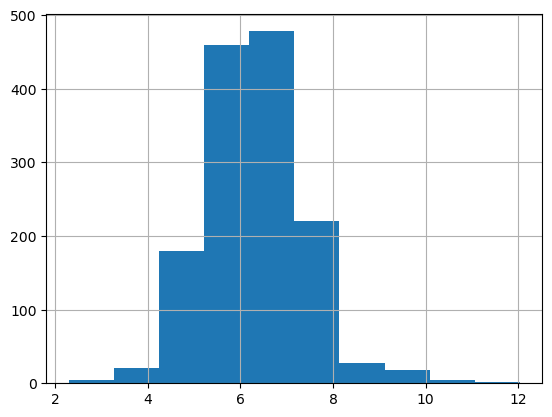

In [150]:
train_df_nonzero['TargetSales_log'].hist()

In [151]:
predictor_reg = TabularPredictor(label='TargetSales_log').fit(train_df_nonzero[selected_features+['TargetSales_log']],
                                                      presets=preset,
                                                      excluded_model_types=['NN_TORCH','FASTAI','KNN'],
                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_161346"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 01:22:11 UTC 2024
CPU Count:          64
Memory Avail:       466.78 GB / 480.23 GB (97.2%)
Disk Space Avail:   1450.75 GB / 1968.52 GB (73.7%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynam

[1000]	valid_set's rmse: 0.732165
[2000]	valid_set's rmse: 0.730646
[3000]	valid_set's rmse: 0.730279
[4000]	valid_set's rmse: 0.730248
[5000]	valid_set's rmse: 0.730238
[6000]	valid_set's rmse: 0.730238
[7000]	valid_set's rmse: 0.730238


	-0.8114	 = Validation score   (-root_mean_squared_error)
	42.21s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 831.05s of remaining time.
	Ensemble Weights: {'CatBoost_BAG_L1': 0.455, 'ExtraTreesMSE_BAG_L1': 0.227, 'XGBoost_BAG_L1': 0.182, 'LightGBM_BAG_L1': 0.136}
	-0.7698	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
Excluded models: ['NN_TORCH', 'FASTAI'] (Specified by `excluded_model_types`)
Fitting 7 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 830.98s of the 830.98s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.7955	 = Validation score   (-root_mean_squared_error)
	5.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 825.34s of the 825.33s of remaining time.
	Fitting 8 child models

[1000]	valid_set's rmse: 0.776795


	-0.7972	 = Validation score   (-root_mean_squared_error)
	7.51s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 817.73s of the 817.72s of remaining time.
	-0.8017	 = Validation score   (-root_mean_squared_error)
	0.67s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 816.81s of the 816.8s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.7824	 = Validation score   (-root_mean_squared_error)
	5.55s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 811.18s of the 811.18s of remaining time.
	-0.7873	 = Validation score   (-root_mean_squared_error)
	0.61s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ... Training model for up to 810.31s of the 810.3s of remaining time.
	Fitting 8 child models (S1F1 -

[1000]	valid_set's rmse: 0.741321
[2000]	valid_set's rmse: 0.735104
[1000]	valid_set's rmse: 0.756407
[1000]	valid_set's rmse: 0.712855


	-0.7869	 = Validation score   (-root_mean_squared_error)
	9.95s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 3428.15s of the 3428.14s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.7932	 = Validation score   (-root_mean_squared_error)
	6.95s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 3421.11s of the 3421.1s of remaining time.
	-0.8097	 = Validation score   (-root_mean_squared_error)
	0.7s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3420.15s of the 3420.15s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.7847	 = Validation score   (-root_mean_squared_error)
	9.03s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Tra

[1000]	valid_set's rmse: 0.75982
[2000]	valid_set's rmse: 0.759573
[1000]	valid_set's rmse: 0.838684
[2000]	valid_set's rmse: 0.838386


	-0.8107	 = Validation score   (-root_mean_squared_error)
	31.41s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 3372.32s of remaining time.
	Ensemble Weights: {'CatBoost_BAG_L1': 0.333, 'LightGBMXT_BAG_L2': 0.25, 'LightGBM_BAG_L2': 0.167, 'LightGBM_BAG_L1': 0.083, 'ExtraTreesMSE_BAG_L1': 0.083, 'LightGBMLarge_BAG_L2': 0.083}
	-0.7746	 = Validation score   (-root_mean_squared_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 106.52s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 1175.2 rows/s (177 batch size)
Automatically performing refit_full as a post-fit operation (due to `.fit(..., refit_full=True)`
Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_

In [152]:
test_df_nonzero['pred_log'] = predictor_reg.predict(test_df_nonzero[selected_features])
test_df_nonzero['pred_log_exp'] = test_df_nonzero['pred_log'].map(np.exp)

test_df['pred_log'] = predictor_reg.predict(test_df[selected_features])
test_df['pred_log_exp'] = test_df['pred_log'].map(np.exp)

In [153]:
calculate_regression_metrics(test_df_nonzero['TargetSales'], test_df_nonzero['pred_log_exp'])

{'root_mean_squared_error': 4330.443144695726,
 'mean_squared_error': 18752737.82944221,
 'mean_absolute_error': 880.0418223064565,
 'r2': 0.3647576298877435,
 'pearsonr': 0.6756393928483335,
 'spearmanr': 0.5762190201444638,
 'median_absolute_error': 243.0658528752748,
 'earths_mover_distance': 546.7166312173882}

In [154]:
test_df['pred_hurdle'] = test_df.pred_binary * test_df.pred_log_exp

In [155]:
metric_hurdle = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_hurdle'])
metric_hurdle['model'] = 'hurdle'
metric_hurdle

{'root_mean_squared_error': 3171.760744960863,
 'mean_squared_error': 10060066.22327469,
 'mean_absolute_error': 584.9162934881963,
 'r2': 0.3779813431428882,
 'pearsonr': 0.6769697889999318,
 'spearmanr': 0.5107083593715698,
 'median_absolute_error': 199.1780137692856,
 'earths_mover_distance': 286.381442541919,
 'model': 'hurdle'}

### [Duan's Method](https://www.jstor.org/stable/2288126)

When predicting a log-transformed outcome, we typically want to re-transform the predictions to non-log numbers by applying the exponential function. However, this ignores a small bias due to the error term in the process.

$$ln(y) = f(X) + \epsilon$$

where 
* $y$ is actual outcome.
* $X$ is the features.
* $f(.)$ is a trained model.
* $\epsilon$ is the error term.

when re-transforming
$$
\begin{align}
y &= exp(ln(y)) \\
&= exp(f(X) + \epsilon ) \\
&= exp(f(X)) \cdot exp(\epsilon) \\
E[y] &= E[exp(f(X))] \cdot E[exp(\epsilon)]
\end{align}
$$

Duan estimates the E[$exp(\epsilon)$] as 
$$
\begin{align}
\hat \lambda &= E[exp(ln(y) - ln(\hat y))]
\end{align}
$$

where 
* $\hat \lambda$ is the Duan's smearing estimator of the bias from re-transformation $E[exp(\epsilon)]$
* $\hat y$ is the prediction aka $f(X)$


In [156]:
train_df_nonzero['pred_log'] = predictor_reg.predict(train_df_nonzero[selected_features])
train_df_nonzero['pred_log_exp'] = train_df_nonzero['pred_log'].map(np.exp)

smearing_estimator = np.mean(np.exp(train_df_nonzero['TargetSales_log'] - train_df_nonzero['pred_log']))
smearing_estimator

1.2280991653046711

<AxesSubplot:>

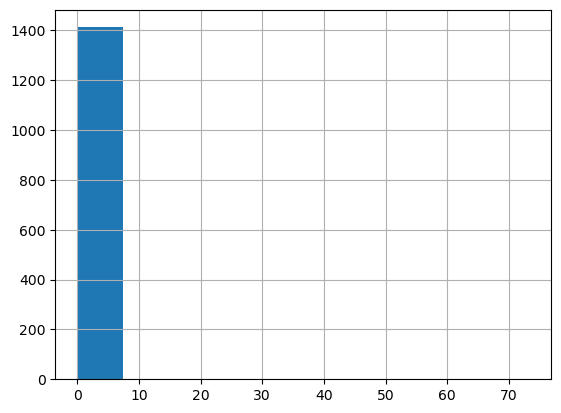

In [157]:
np.exp(train_df_nonzero['TargetSales_log'] - train_df_nonzero['pred_log']).hist()

In [158]:
test_df['pred_log_exp_corrected'] = test_df['pred_log_exp'] * smearing_estimator
test_df['pred_hurdle_corrected'] = test_df.pred_binary * test_df.pred_log_exp_corrected

In [159]:
metric_hurdle_corrected = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_hurdle_corrected'])
metric_hurdle_corrected['model'] = 'hurdle_corrected'
metric_hurdle_corrected

{'root_mean_squared_error': 3055.3207868281233,
 'mean_squared_error': 9334985.110424023,
 'mean_absolute_error': 613.3946643257099,
 'r2': 0.42281345159207295,
 'pearsonr': 0.6769697889999318,
 'spearmanr': 0.5107083593715698,
 'median_absolute_error': 232.55557358084502,
 'earths_mover_distance': 241.61839859133218,
 'model': 'hurdle_corrected'}

### Assumption on Independent and Identically Distributed Residuals

But not so fast, the formulation of Duan's smearing estimator assumes that estimates of error terms (residuals) for log predictions be independent and identically distributed. Since we are dealing with individual customers, independence can be assumed. However, if we look at the plot of residuals vs predicted log values, we can see that they are not identically distributed.

<AxesSubplot:xlabel='pred_log', ylabel='residual_log'>

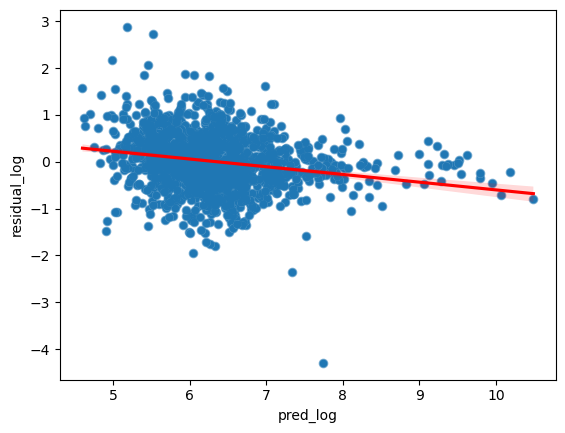

In [271]:
#plot residual and predicted log value
train_df_nonzero['pred_log'] = predictor_reg.predict(train_df_nonzero[selected_features])
train_df_nonzero['residual_log'] = (train_df_nonzero['pred_log'] - train_df_nonzero['TargetSales_log'])

# Create the scatter plot
sns.scatterplot(x='pred_log', y='residual_log', data=train_df_nonzero)

# Add the Lowess smoothing line
sns.regplot(x='pred_log', y='residual_log', data=train_df_nonzero, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

Although note that [White test](https://en.wikipedia.org/wiki/White_test) does not reject the null hypothesis of the residuals being homoscedastic in reference to the features. This counterintuitive result might stem from the fact that White test is assuming linear or quadratic relationships between outcome and features while the residuals are derived from a stacked ensemble of decision trees.

In [161]:
white_stat, white_p_value, _, _ = het_white(train_df_nonzero['residual_log'], 
                                            train_df_nonzero[selected_features])
print(f"White Test Statistic: {white_stat}")
print(f"P-value: {white_p_value}")

White Test Statistic: 129.31318320644837
P-value: 0.8761278601130765


Our choice is to either trust the White test and ~~pretend~~ assume everything is fine; or trust our eyes and replace the non-zero regression model with one that produces iid residuals such as [generalized least squares (GLS)](https://en.wikipedia.org/wiki/Generalized_least_squares) with heteroscedasticity-robust standard errors. In order to satisfy the assumptions of GLS, we perform winsorization, standardization and verify multicollinearity among the features.

In [248]:
train_df_nonzero_processed = train_df_nonzero.copy()

#winsorize at 99%
winsorizer = Winsorizer(cols=selected_features, percentile=99)
winsorizer.fit(train_df_nonzero_processed)
train_df_nonzero_processed = winsorizer.transform(train_df_nonzero_processed)

#standard scaling
scaler = StandardScaler()
scaler.fit(train_df_nonzero_processed[selected_features])
train_df_nonzero_processed[selected_features] = scaler.transform(train_df_nonzero_processed[selected_features])

#check vif
vif_data = calculate_vif(train_df_nonzero_processed, selected_features)

# Print the VIF for each feature
print(vif_data)

# Filter out features with high VIF (e.g., VIF > 10 suggests multicollinearity)
high_vif_features = vif_data[vif_data['VIF'] > 10]
print("High VIF features:", high_vif_features)

                           feature        VIF
0                            const   1.000000
1                          recency   3.976800
2                     purchase_day   6.193391
3                      total_sales   5.837235
4                       nb_product   2.386644
5                      nb_category   2.691338
6                customer_lifetime   2.271404
7           avg_purchase_frequency   5.291575
8               avg_purchase_value   2.449152
9          per_fashion_accessories   5.826894
10                  per_home_decor  15.806683
11          per_kitchen_and_dining  12.053308
12                      per_others   1.779531
13          per_outdoor_and_garden   2.729103
14  per_personal_care_and_wellness   2.908001
15        per_seasonal_and_holiday   4.234883
16        per_stationary_and_gifts   4.252687
17              per_toys_and_games   3.185269
High VIF features:                    feature        VIF
10          per_home_decor  15.806683
11  per_kitchen_and_dining  12.

In [249]:
# Calculate VIF after dropping highly correlated features
selected_features_no_corr = [i for i in selected_features if i!='per_kitchen_and_dining']
vif_data = calculate_vif(train_df_nonzero_processed.drop('per_kitchen_and_dining',axis=1), 
                         selected_features_no_corr)

# Print the VIF for each feature
print(vif_data)

# Filter out features with high VIF (e.g., VIF > 10 suggests multicollinearity)
high_vif_features = vif_data[vif_data['VIF'] > 10]
print("High VIF features:", high_vif_features)

                           feature       VIF
0                            const  1.000000
1                          recency  3.975755
2                     purchase_day  6.193274
3                      total_sales  5.835455
4                       nb_product  2.355212
5                      nb_category  2.238039
6                customer_lifetime  2.265888
7           avg_purchase_frequency  5.288665
8               avg_purchase_value  2.447088
9          per_fashion_accessories  1.271944
10                  per_home_decor  1.642046
11                      per_others  1.172240
12          per_outdoor_and_garden  1.122673
13  per_personal_care_and_wellness  1.141183
14        per_seasonal_and_holiday  1.180130
15        per_stationary_and_gifts  1.310125
16              per_toys_and_games  1.198112
High VIF features: Empty DataFrame
Columns: [feature, VIF]
Index: []


In [272]:
y = train_df_nonzero_processed['TargetSales_log']
X = train_df_nonzero_processed[selected_features_no_corr]
X = sm.add_constant(X)

gls_model = sm.GLS(y, X)
gls_results = gls_model.fit(cov_type='HC3')

# 4. Print the summary of the regression
print(gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:        TargetSales_log   R-squared:                       0.460
Model:                            GLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     75.24
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          2.27e-175
Time:                        16:56:46   Log-Likelihood:                -1661.3
No. Observations:                1414   AIC:                             3357.
Df Residuals:                    1397   BIC:                             3446.
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

<AxesSubplot:xlabel='pred_log_gls', ylabel='residual_log_gls'>

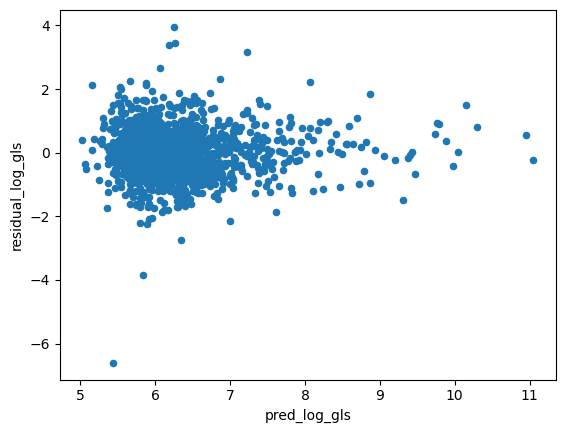

In [273]:
#plot residual and predicted log value
train_df_nonzero_processed['pred_log_gls'] = gls_results.predict(X).reset_index(drop=True)
train_df_nonzero_processed['residual_log_gls'] = (train_df_nonzero_processed['pred_log_gls'] - train_df_nonzero_processed['TargetSales_log'])
train_df_nonzero_processed.plot.scatter(x='pred_log_gls', y='residual_log_gls')

In [274]:
white_stat, white_p_value, _, _ = het_white(train_df_nonzero_processed['residual_log_gls'], 
                                            X)
print(f"White Test Statistic: {white_stat}")
print(f"P-value: {white_p_value}")

White Test Statistic: 135.0623196454856
P-value: 0.8343390085729777


In [275]:
#preprocess test set
test_df_processed = test_df.copy()

#winsorize at 99%
test_df_processed = winsorizer.transform(test_df_processed)

#standard scaling
test_df_processed[selected_features] = scaler.transform(test_df_processed[selected_features])

#drop highly correlated features
test_df_processed = test_df_processed.drop('per_kitchen_and_dining', axis=1)

#infer
X_test = test_df_processed[selected_features_no_corr]
X_test = sm.add_constant(X_test)
test_df_processed['pred_log_gls'] = gls_results.predict(X_test)

In [276]:
smearing_estimator_gls = np.mean(np.exp(train_df_nonzero_processed['TargetSales_log'] - train_df_nonzero_processed['pred_log_gls']))
smearing_estimator_gls

1.8597808961776598

In [277]:
test_df['pred_log_exp_gls'] = test_df_processed['pred_log_gls'].map(np.exp)

test_df['pred_log_exp_gls_corrected'] = test_df['pred_log_exp_gls'] * smearing_estimator_gls
test_df['pred_hurdle_gls_corrected'] = test_df.pred_binary * test_df.pred_log_exp_gls_corrected

metric_hurdle_gls_corrected = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_hurdle_gls_corrected'])
metric_hurdle_gls_corrected['model'] = 'hurdle_gls_corrected'
metric_hurdle_gls_corrected

{'root_mean_squared_error': 5289.79271849163,
 'mean_squared_error': 27981907.004607063,
 'mean_absolute_error': 970.7645208697954,
 'r2': -0.73013455627538,
 'pearsonr': 0.7076845600551718,
 'spearmanr': 0.5187878933164471,
 'median_absolute_error': 339.03363694351526,
 'earths_mover_distance': 556.014141615775,
 'model': 'hurdle_gls_corrected'}

## Evaluation

We can see that the `hurdle_corrected` method performs best across all metrics except for 1) mean absolute error where it performs about 5% worse than `hurdle` method without the correction and 2) median absolute error where it only performs better than baseline regression and 3) Spearman's rank correlation where it underperforms `log1p` by 4%; correlations are tied between the two Hurdle methods by definition since we multiply Duan's smearing estimator to `hurdle` predictions to get `hurdle_corrected`.



In [69]:
metric_df = pd.DataFrame([metric_baseline,
                       metric_winsorized,
                       metric_log1p,
                       metric_hurdle,
                       metric_hurdle_corrected,])

In [70]:
rank_df = metric_df.copy()
for col in metric_df.columns.tolist()[:-1]:
    if col in ['r2', 'pearsonr', 'spearmanr']:
        rank_df[f'{col}_rank'] = rank_df[col].rank(ascending=False)
    else:
        rank_df[f'{col}_rank'] = rank_df[col].rank(ascending=True)
rank_df = rank_df.drop(metric_df.columns.tolist()[:-1], axis=1)
rank_df['avg_rank'] = rank_df.iloc[:,1:].mean(axis=1)
rank_df.transpose()

,0,1,2,3,4
model,baseline,winsorized,log1p,hurdle,hurdle_corrected
root_mean_squared_error_rank,2.0,4.0,5.0,3.0,1.0
mean_squared_error_rank,2.0,4.0,5.0,3.0,1.0
mean_absolute_error_rank,5.0,4.0,3.0,1.0,2.0
r2_rank,2.0,4.0,5.0,3.0,1.0
pearsonr_rank,3.0,5.0,4.0,1.5,1.5
spearmanr_rank,5.0,4.0,1.0,2.5,2.5
median_absolute_error_rank,5.0,3.0,1.0,2.0,4.0
earths_mover_distance_rank,3.0,4.0,5.0,2.0,1.0
avg_rank,3.375,4.0,3.625,2.25,1.75


In [71]:
metric_df.transpose()

,0,1,2,3,4
root_mean_squared_error,3162.478744,3623.576378,3725.342296,3171.760745,3055.320787
mean_squared_error,10001271.807776,13130305.763947,13878175.221577,10060066.223275,9334985.110424
mean_absolute_error,715.644266,627.788007,618.976847,584.916293,613.394664
r2,0.381617,0.188147,0.141906,0.377981,0.422813
pearsonr,0.619072,0.575799,0.581717,0.67697,0.67697
spearmanr,0.470085,0.504302,0.533816,0.510708,0.510708
median_absolute_error,232.982083,219.622481,89.554954,199.178014,232.555574
earths_mover_distance,287.777288,432.128843,581.049444,286.381443,241.618399
model,baseline,winsorized,log1p,hurdle,hurdle_corrected


### Why `hurdle` Outperforms `hurdle_corrected` in MAE?

Duan's method adjusts for underestimation from retransformation of log outcome. This could lead to smaller extreme errors but more less extreme ones. We verify this hypothesis by comparing mean absolute error before and after transformation for errors originally under and over 99th percentile. We confirm that is the case for this problem.

In [72]:
err_hurdle = (test_df['TargetSales'] - test_df['pred_hurdle']).abs()
err_hurdle_corrected = (test_df['TargetSales'] - test_df['pred_hurdle_corrected']).abs()

In [73]:
err_hurdle.describe(percentiles=[.25, .5, .75, .9, .95, .99]) 

count      688.000000
mean       584.916293
std       3119.628924
min          0.000000
25%          0.000000
50%        199.178014
75%        475.603446
90%        862.530026
95%       1237.540954
99%       6763.777844
max      55731.205996
dtype: float64

In [74]:
err_hurdle[err_hurdle<6763.777844].mean(),\
err_hurdle[err_hurdle>6763.777844].mean(),

(355.4918014848842, 22904.641872667555)

In [75]:
err_hurdle_corrected[err_hurdle<6763.777844].mean(),\
err_hurdle_corrected[err_hurdle>6763.777844].mean(),

(392.7718802742851, 22076.839798471465)

### Why `log1p` Performs So Much Better than Others in MedAE?

It is for similar reasons that `hurdle` outperforms `hurdle_corrected` in MedAE; however, `log1p` performs twice better than other approaches (it also slightly outperforms `hurdle` models in Spearman's rank correlation), especially the Hurdle models which should be modeling the non-zero outcomes in the same manner. This is because Hurdle models depend not only on the regression but the classification model. We can see that if the classification model were perfect (instead of the current f1 = 0.69), other metrics also improved but not nearly as drastic as MedAE and Spearman's rank correlation.

In [76]:
test_df['pred_hurdle_corrected_perfect_cls'] = test_df.has_purchase * test_df.pred_log_exp_corrected
metric_hurdle_corrected_perfect_cls = calculate_regression_metrics(test_df['TargetSales'], test_df['pred_hurdle_corrected_perfect_cls'])
metric_hurdle_corrected_perfect_cls['model'] = 'hurdle_corrected_perfect_cls'

metric_df2 = pd.DataFrame([metric_baseline,
                       metric_winsorized,
                       metric_log1p,
                       metric_hurdle,
                       metric_hurdle_corrected,
                       metric_hurdle_corrected_perfect_cls,])
metric_df2.transpose()


,0,1,2,3,4,5
root_mean_squared_error,3162.478744,3623.576378,3725.342296,3171.760745,3055.320787,3030.854831
mean_squared_error,10001271.807776,13130305.763947,13878175.221577,10060066.223275,9334985.110424,9186081.006625
mean_absolute_error,715.644266,627.788007,618.976847,584.916293,613.394664,479.558294
r2,0.381617,0.188147,0.141906,0.377981,0.422813,0.43202
pearsonr,0.619072,0.575799,0.581717,0.67697,0.67697,0.687639
spearmanr,0.470085,0.504302,0.533816,0.510708,0.510708,0.929419
median_absolute_error,232.982083,219.622481,89.554954,199.178014,232.555574,34.991964
earths_mover_distance,287.777288,432.128843,581.049444,286.381443,241.618399,234.587018
model,baseline,winsorized,log1p,hurdle,hurdle_corrected,hurdle_corrected_perfect_cls


### Why Baseline Regression Performs Best at Aggregate Level

If we look at aggregated mean or sum of actual sales vs predicted sales, baseline regression performs best by far. This is due to the fact that without any constraints a regressor only minimizes the MSE loss and usually ends up predicting values around the mean to balance between under- and over-predictions. However, this level of prediction is often not very useful as a single point and more often done by in a time series setup.

In [77]:
test_df[['TargetSales','pred_baseline','pred_winsorized','pred_log1p_expm1','pred_hurdle','pred_hurdle_corrected']].mean()

TargetSales              760.558808
pred_baseline            791.043945
pred_winsorized          508.281555
pred_log1p_expm1         186.200281
pred_hurdle              527.286811
pred_hurdle_corrected    647.560493
dtype: float64

In [78]:
test_df[['TargetSales','pred_baseline','pred_winsorized','pred_log1p_expm1','pred_hurdle','pred_hurdle_corrected']].sum()

TargetSales              523264.460000
pred_baseline            544238.250000
pred_winsorized          349697.718750
pred_log1p_expm1         128105.793618
pred_hurdle              362773.326124
pred_hurdle_corrected    445521.619008
dtype: float64